In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [18]:
from scipy.io.wavfile import read as wavread

fs, keir = wavread('keircrop.wav')
keir = (keir.astype(np.float64)) / 32767.0
keir = np.mean(keir, axis=1)

In [38]:
hop_size = 256
window_len = 1024
start = 1368273
end = start + 126535

keir_slices = []
for i in range(start, end, window_len):
    if i + window_len >= len(keir):
        continue
    window = keir[i:i + window_len]
    keir_slices.append(window)
keir_slices = np.array(keir_slices)
print keir_slices.shape

(124L, 1024L)


In [90]:
keir_windowed = np.hanning(window_len) * keir_slices
keir_stft = np.fft.rfft(keir_slices, axis=1)
keir_mag = np.abs(keir_stft)
keir_phase = np.angle(keir_stft)
keir_stft_split = np.stack([keir_mag, keir_phase], axis=1)
print keir_stft_split.shape

(124L, 2L, 513L)


In [99]:
from sklearn.decomposition import PCA

n_components = 112

#keir_data = keir_slices
keir_data = np.reshape(keir_stft_split, (-1, 1026))

pca = PCA(n_components=n_components)
pca.fit(keir_data)
print np.sum(pca.explained_variance_ratio_)

0.99029633231


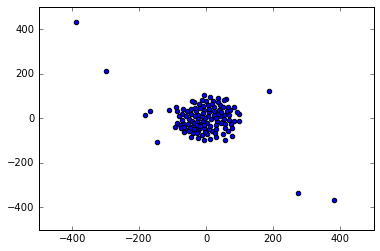

In [119]:
from sklearn.manifold import TSNE

#pca_data = keir_data
pca_data = pca.transform(keir_data)
tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(pca_data)
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])

(1000L, 112L)


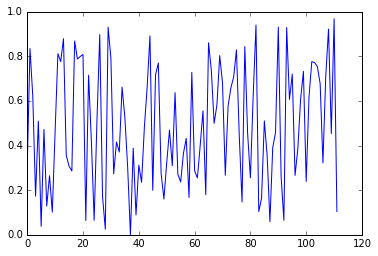

In [153]:
from scipy.signal import remez, filtfilt

n_noise = 5
n_windows = 1000

noise = np.random.rand(n_noise, n_components)
n_upsample = n_windows / n_noise
noise_up = np.zeros((n_upsample, n_noise, n_components))
noise_up[0] = noise
noise_up = np.reshape(noise_up, (-1, n_components))
print noise_up.shape

cutoff = 0.5 / n_upsample
noise_filter = remez(256, [0.0, cutoff, cutoff + 0.01, 0.5], [1, 0])
noise_filtered = filtfilt(noise_filter, [1.0], noise_up, axis=0)

plt.plot(noise_filtered[1])

noise_transform = pca.inverse_transform(noise_filtered)
noise_stft_split = np.reshape(noise_transform, (n_windows, 2, -1))
noise_stft = noise_stft_split[:, 0] * np.exp(noise_stft_split[:, 1])
noise_windowed = np.fft.irfft(noise_stft, axis=1)

output_len = n_windows * hop_size
output = np.zeros(n_windows * window_len)
for window_i, i in enumerate(xrange(0, output_len, hop_size)):
    output[i:i + window_len] += noise_windowed[window_i]

from IPython.display import Audio

Audio(output, rate=fs)